In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

col_names = ['Name', 'Risk', 'Return']

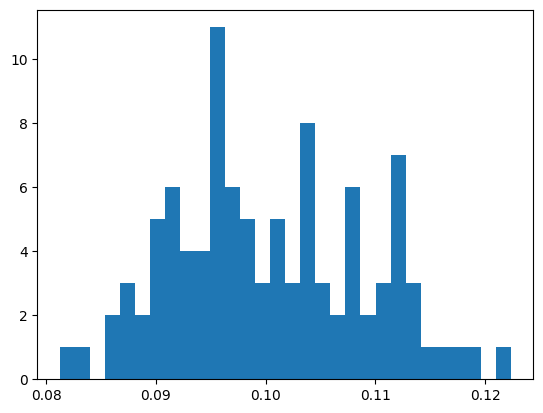

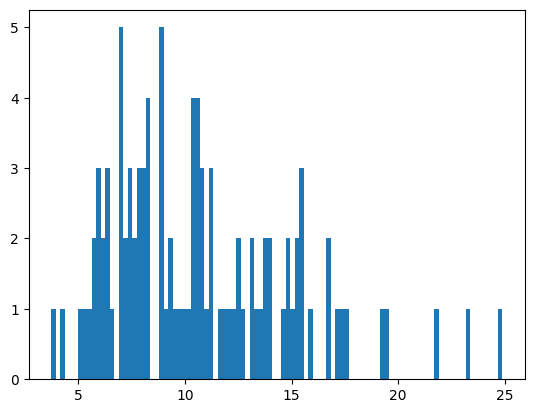

In [3]:
#cell to generate random data
rand_data = []
num_pts = 100

mean = 10 # average log normal return
returns_noise = 0.5 # log normal returns

for i in range(num_pts):
    risk = np.max(1 / (mean + np.random.normal()), 0)
    rand_data.append(["Disease " + str(i), risk, np.exp(np.log(mean) + returns_noise * np.random.normal())])
    
rand_data_df = pd.DataFrame(rand_data, columns = col_names)
rand_data_df.to_csv("./riskreturn.csv", index=False)

plt.figure()
plt.hist(rand_data_df['Risk'].tolist(), bins = 30)
plt.show()

plt.figure()
plt.hist(rand_data_df['Return'].tolist(), bins = 100)
plt.show()


In [4]:
data = pd.read_csv('./riskreturn.csv')

print(data)

          Name      Risk     Return
0    Disease 0  0.095016  15.525749
1    Disease 1  0.081263   8.305768
2    Disease 2  0.092433   7.007052
3    Disease 3  0.091488  17.618339
4    Disease 4  0.093744  19.576720
..         ...       ...        ...
95  Disease 95  0.098914  15.472117
96  Disease 96  0.113189  15.373128
97  Disease 97  0.101216   7.088422
98  Disease 98  0.107545  12.654736
99  Disease 99  0.091478   5.900957

[100 rows x 3 columns]


In [5]:
n = len(data)
CovarRisk = np.array([[(data['Risk'][i]**2 if i == j else 0) for i in range(n)] for j in range(n)])
MeanReturns = data['Return'].tolist()

def MaximizeReturns(data, PortfolioSize): #optimize with no risk
    c = np.multiply(-1, data['Return'].tolist())
    A = np.ones([PortfolioSize, 1]).T
    b = [1]
    weights = opt.linprog(c, A_ub = A, b_ub = b, bounds = (0,1))
    return weights.x

def MinimizeReturns(data, size):
    def f(x):
        func = np.matmul(np.matmul(x, CovarRisk), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, size)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    weights = opt.minimize (f, x0 = xinit,  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
    return weights.x
    
def MeanVar(data, size, R):    
    def f(x, CovarRisk):
        return np.matmul(np.matmul(x, CovarRisk), x.T) 

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq, x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, size)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    res = opt.minimize (f, args = (CovarRisk), method ='trust-constr', x0 = xinit, bounds = bnds, constraints = cons)
    
    # if res.success == False:
    #     print("OPTIMIZE FAIL") 
    # else:
    #     print("OPTIMIZE SUCCESS") 
    return res.x

# print(MeanVar(data, 10, 10))

In [9]:
def ComputeReturns(data, weights):
    return np.matmul(np.array(data['Return'].tolist()), weights.T)

def ComputeRisk(weights, n):
    return np.sqrt(np.matmul(np.matmul(weights, CovarRisk), weights.T)) / np.sqrt(n)

n = len(data)
incr = 1
min = ComputeReturns(data, MinimizeReturns(data, n))
max = ComputeReturns(data, MaximizeReturns(data, n))

print(min)
print(max)

frontier_risk = []
frontier_return = []

R = min # target return
while R < max:
    res = MeanVar(data, n, R)
    frontier_risk.append(ComputeRisk(res, n))
    frontier_return.append(R)
    R += incr
    # print(R)

10.694073199390841
24.871829638896504


c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Text(0, 0.5, 'Expected Return (%)')

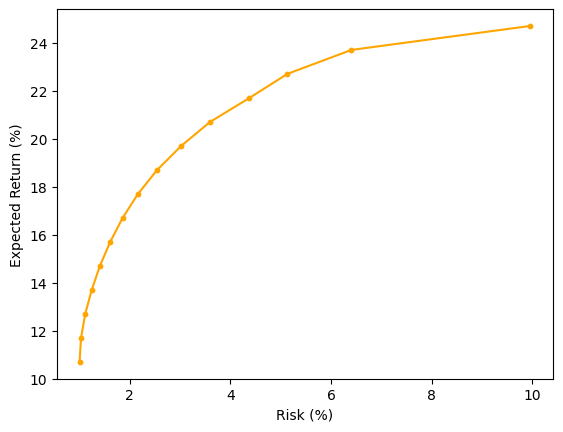

In [10]:
#plot results
plt.figure()
plt.plot(np.array(frontier_risk) * 100, frontier_return, color='orange')
plt.scatter(np.array(frontier_risk) * 100, frontier_return, s=10, color='orange')
plt.xlabel("Risk (%)")
plt.ylabel("Expected Return (%)")

0.032
0.1
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038000000000000006
0.03900000000000001
0.04000000000000001
0.04100000000000001
0.04200000000000001
0.04300000000000001
0.04400000000000001
0.04500000000000001
0.04600000000000001
0.047000000000000014
0.048000000000000015
0.049000000000000016
0.05000000000000002
0.05100000000000002
0.05200000000000002
0.05300000000000002
0.05400000000000002
0.05500000000000002
0.05600000000000002
0.05700000000000002
0.058000000000000024
0.059000000000000025
0.060000000000000026
0.061000000000000026
0.06200000000000003
0.06300000000000003
0.06400000000000003
0.06500000000000003
0.06600000000000003
0.06700000000000003
0.06800000000000003
0.06900000000000003
0.07000000000000003
0.07100000000000004
0.07200000000000004
0.07300000000000004
0.07400000000000004
0.07500000000000004
0.07600000000000004
0.07700000000000004
0.07800000000000004
0.07900000000000004
0.08000000000000004
0.08100000000000004
0.08200000000000005
0.08300000000000005
0.

Text(0, 0.5, 'Expected Return (%)')

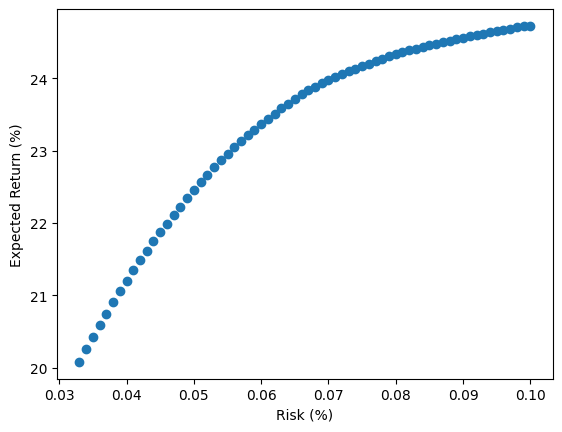

In [12]:
from pypfopt.efficient_frontier import EfficientFrontier
import pypfopt.objective_functions as objective_functions

expected_returns = data['Return']
cov_matrix = np.array([[(data['Risk'][i]**2 if i == j else 0) for i in range(n)] for j in range(n)])

ef = EfficientFrontier(expected_returns, cov_matrix)
ef.add_objective(objective_functions.L2_reg)
weights = ef.efficient_risk(0.04)
n = len(data)
incr = 0.001
min = 0.032
max = 0.1

print(min)
print(max)

frontier_risk = []
frontier_return = []

R = min # risk tolerance
while R < max:
    res = ef.efficient_risk(R)
    res = np.array([i[1] for i in res.items()])
    R += incr
    frontier_risk.append(R)
    frontier_return.append(ComputeReturns(data, res))
    print(R)
    
plt.figure()
plt.scatter(frontier_risk, frontier_return)
plt.xlabel("Risk (%)")
plt.ylabel("Expected Return (%)")